In [1]:
# Wrangling data
from scipy.io import arff
import numpy as np
import pandas as pd
import warnings
import re

# Visualizing the data 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Some aggregation to statisticize data 
from scipy.stats.mstats import trimmed_var
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Build model
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Evaluate model
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

In [2]:
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.3f}'.format

# Import data

In [12]:
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    data = arff.loadarff(filename)[0]
        
    # Load dictionary into DataFrame, set index
    df = pd.DataFrame(data=data)
    
    # Rename columns
    df.columns = [re.sub(pattern='Attr',repl='feat_',string=col) for col in df.columns]
    df.rename(columns={'class':'bankrupt'},inplace=True)
    
    # Change dtype of the Labels columns
    df['bankrupt'] = df['bankrupt'].astype(np.int64)
    return df

In [25]:
file_path = 'dataset/3year.arff'
df = wrangle(file_path)
bankrupt_df = df.copy()
print("Shape of DataFrame:",bankrupt_df.shape)
bankrupt_df.head()

Shape of DataFrame: (10503, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
0,0.174,0.413,0.144,1.348,-28.982,0.604,0.219,1.123,1.196,0.464,...,0.164,0.376,0.836,0.000,9.714,6.281,84.291,4.330,4.034,0
1,0.146,0.460,0.282,1.629,2.595,0.000,0.172,1.172,1.602,0.540,...,0.028,0.271,0.901,0.000,5.988,4.110,102.190,3.572,5.950,0
2,0.001,0.226,0.488,3.160,84.874,0.191,0.005,2.988,1.008,0.676,...,0.008,0.001,0.992,0.000,6.774,3.792,64.846,5.629,4.458,0
3,0.025,0.432,0.275,1.783,-10.105,0.569,0.025,1.306,1.051,0.565,...,0.048,0.043,0.952,0.143,4.229,5.053,98.783,3.695,3.484,0
4,0.188,0.415,0.342,1.928,-58.274,0.000,0.234,1.409,1.339,0.585,...,0.176,0.322,0.826,0.073,2.591,7.076,100.540,3.630,4.638,0


# Explore data

## Overview data

In [26]:
bankrupt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10503 entries, 0 to 10502
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feat_1    10503 non-null  float64
 1   feat_2    10503 non-null  float64
 2   feat_3    10503 non-null  float64
 3   feat_4    10485 non-null  float64
 4   feat_5    10478 non-null  float64
 5   feat_6    10503 non-null  float64
 6   feat_7    10503 non-null  float64
 7   feat_8    10489 non-null  float64
 8   feat_9    10500 non-null  float64
 9   feat_10   10503 non-null  float64
 10  feat_11   10503 non-null  float64
 11  feat_12   10485 non-null  float64
 12  feat_13   10460 non-null  float64
 13  feat_14   10503 non-null  float64
 14  feat_15   10495 non-null  float64
 15  feat_16   10489 non-null  float64
 16  feat_17   10489 non-null  float64
 17  feat_18   10503 non-null  float64
 18  feat_19   10460 non-null  float64
 19  feat_20   10460 non-null  float64
 20  feat_21   9696 non-null   fl

- Missing value Percentage of all columns

In [27]:
(bankrupt_df.isna().sum()/bankrupt_df.shape[0]).sort_values(ascending=False).head(10)

feat_37   0.451
feat_21   0.077
feat_27   0.068
feat_60   0.056
feat_45   0.056
feat_28   0.022
feat_53   0.022
feat_54   0.022
feat_64   0.022
feat_24   0.022
dtype: float64

In [28]:
# drop the feat 37 because the missing propotion is more than 40%
bankrupt_df.drop(columns='feat_37',inplace=True)

## Data Analysis 

- As we aim to predict whether a corporation is branrupted, let take a look about that column carefully

### Label columns 

In [74]:
round(bankrupt_df['bankrupt'].value_counts(normalize=True),2).values

0   0.950
1   0.050
Name: bankrupt, dtype: float64

In [75]:
bankrupt_count = bankrupt_df['bankrupt'].value_counts().to_frame()
bankrupt_count['Class'] = ['False','True']
bankrupt_count['Propotion'] = round(bankrupt_df['bankrupt'].value_counts(normalize=True),2).values
bankrupt_count

,bankrupt,Class,Propotion
0,10008,False,0.950
1,495,True,0.050


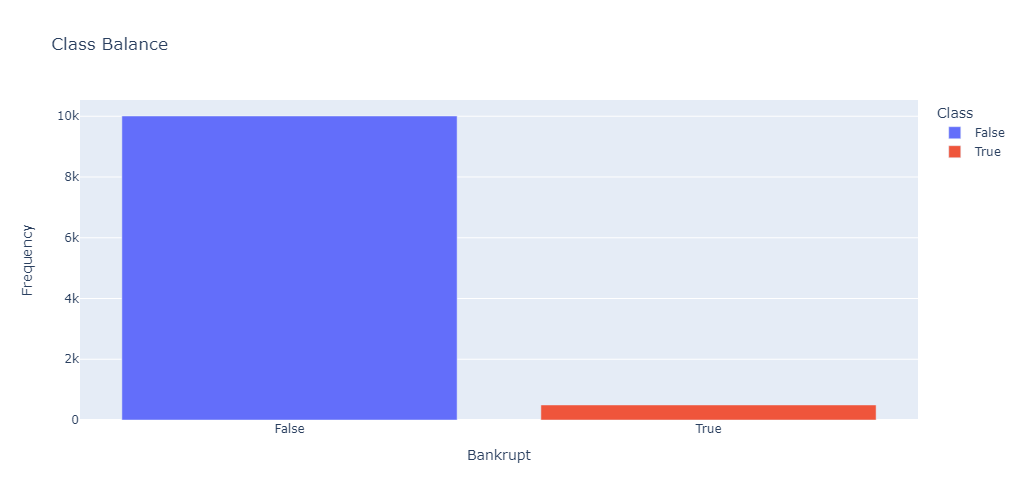

In [80]:
# Plot class balance
fig = px.bar(data_frame=bankrupt_count,
             x='Class',
             y='bankrupt',
             hover_data=['Propotion'],
             color='Class',
             title='Class Balance',
             height=500
            )
fig.update_layout(xaxis_title='Bankrupt',yaxis_title='Frequency')
fig.show()

From the visualization, in three-year period, the financial situation performed effectively in Poland. However,it also shows us that we have an imbalanced dataset, where our majority class (0) is far bigger than our minority class (1). 

Let combine some particular features to have a view genarally about the Labels:

- `feat_27`: profit on operating activities / financial expenses

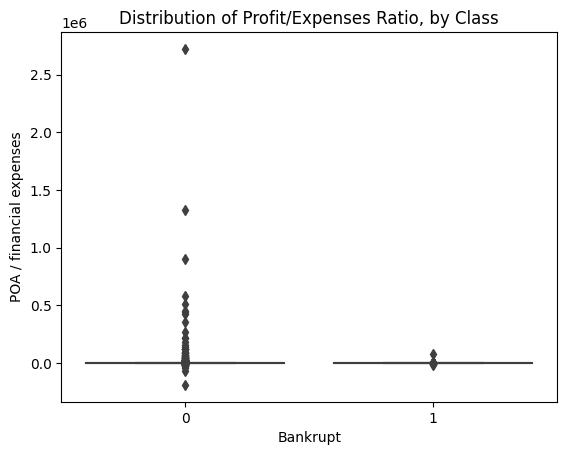

In [33]:
# Create boxplot
sns.boxplot(data=bankrupt_df,x='bankrupt',y='feat_27')
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Class")
plt.show()

In [35]:
# Summary statistics for `feat_27`
bankrupt_df['feat_27'].describe().apply("{0:,.2f}".format)

count        9,788.00
mean         1,185.95
std         34,691.23
min       -190,130.00
25%              0.00
50%              1.07
75%              4.81
max      2,723,000.00
Name: feat_27, dtype: object

Note that the median is around 1, but the mean is over 1000. That suggests that this feature is skewed to the right.

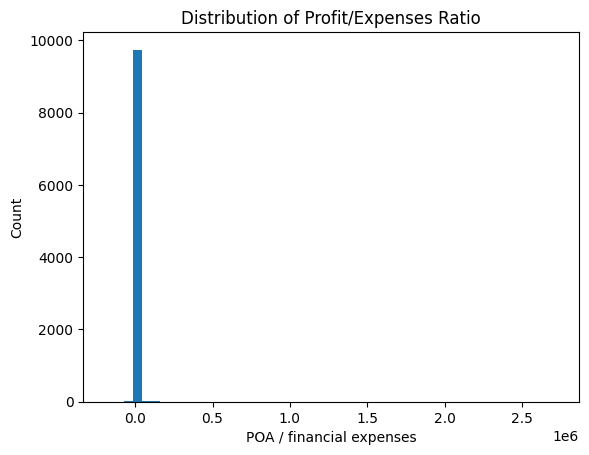

In [37]:
# Plot histogram of `feat_27`
bankrupt_df['feat_27'].hist(bins=50,grid=False)
plt.xlabel("POA / financial expenses")
plt.ylabel("Count"),
plt.title("Distribution of Profit/Expenses Ratio")
plt.show()

There are so many outliers. Since this historgram is showing a big skewness for this feature.

Let create again the boxplot but this time only using the data from 0.1 to 0.9 quantiles

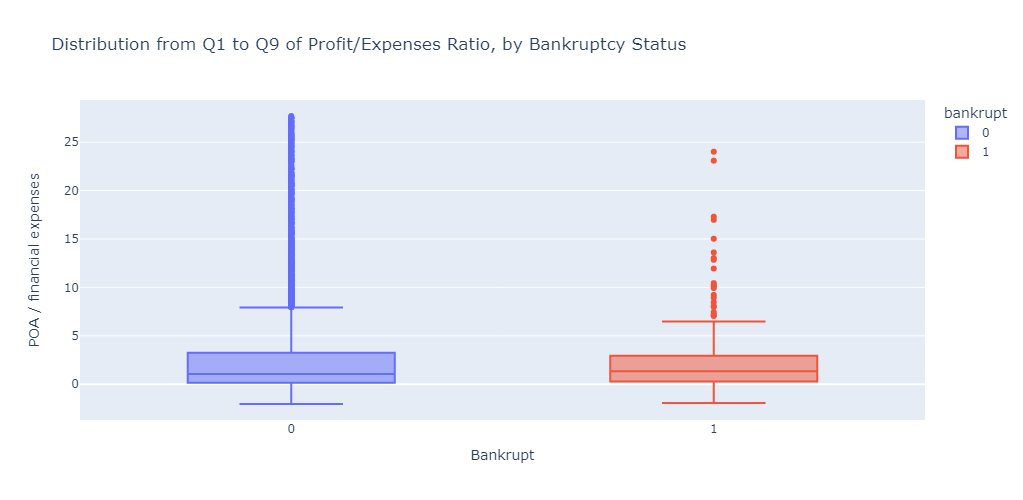

In [86]:
q1, q9 = bankrupt_df['feat_27'].quantile([0.1,0.9])
mask = bankrupt_df['feat_27'].between(q1,q9)

fig = px.box(data_frame=bankrupt_df[mask],
             x='bankrupt',
             y='feat_27',
             height=500,
             color='bankrupt',
             title="Distribution from Q1 to Q9 of Profit/Expenses Ratio, by Bankruptcy Status")
fig.update_layout(xaxis_title= 'Bankrupt',yaxis_title= "POA / financial expenses")
fig.show()

<div class="alert alert-info" role="alert">
    <p><b>More context on <code>"feat_27"</code>:</b> <em>Profit on operating activities</em> is profit that a company makes through its "normal" operations. For instance, a car company profits from the sale of its cars. However, a company may have other forms of profit, such as financial investments. So a company's <em>total profit</em> may be positive even when its profit on operating activities is negative.
    <p><em>Financial expenses</em> include things like interest due on loans, and does not include "normal" expenses (like the money that a car company spends on raw materials to manufacture cars). 
</div>

In [46]:
# Explore another feature to check whether there is a skewness  
bankrupt_df['feat_39'].describe()

count   10460.000
mean       -0.076
std         8.079
min      -551.110
25%         0.002
50%         0.034
75%         0.091
max       293.150
Name: feat_39, dtype: float64

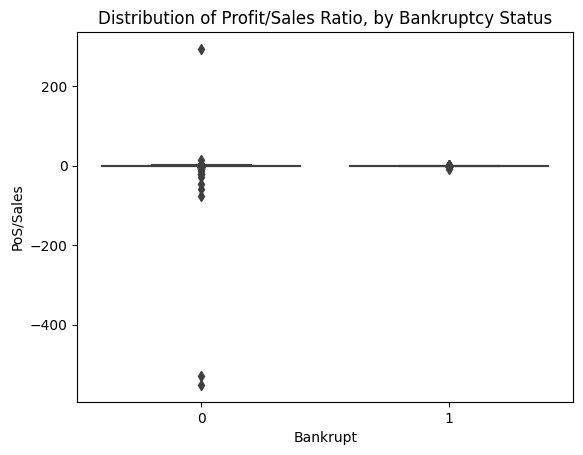

In [48]:
sns.boxplot(data=bankrupt_df,x='bankrupt',y='feat_39')
plt.xlabel("Bankrupt")
plt.ylabel("PoS/Sales")
plt.title("Distribution of Profit/Sales Ratio, by Bankruptcy Status")
plt.show()

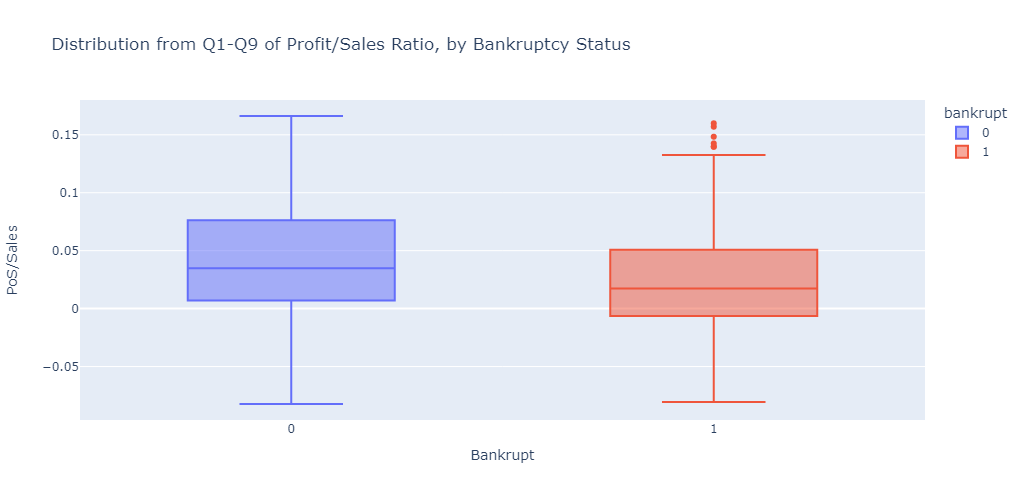

In [87]:
q1, q9 = bankrupt_df['feat_39'].quantile([0.1,0.9])
mask = bankrupt_df['feat_39'].between(q1,q9)

fig = px.box(data_frame=bankrupt_df[mask],
             x='bankrupt',
             y='feat_39',
             height=500,
             color='bankrupt',
             title="Distribution from Q1-Q9 of Profit/Sales Ratio, by Bankruptcy Status")
fig.update_layout(xaxis_title= 'Bankrupt',yaxis_title= "PoS/Sales")
fig.show()

Looking at other features, we can see that they're skewed, too. This will be important to keep in mind when we decide what type of model we want to use.

- Check whether data encountered the multicollinearity

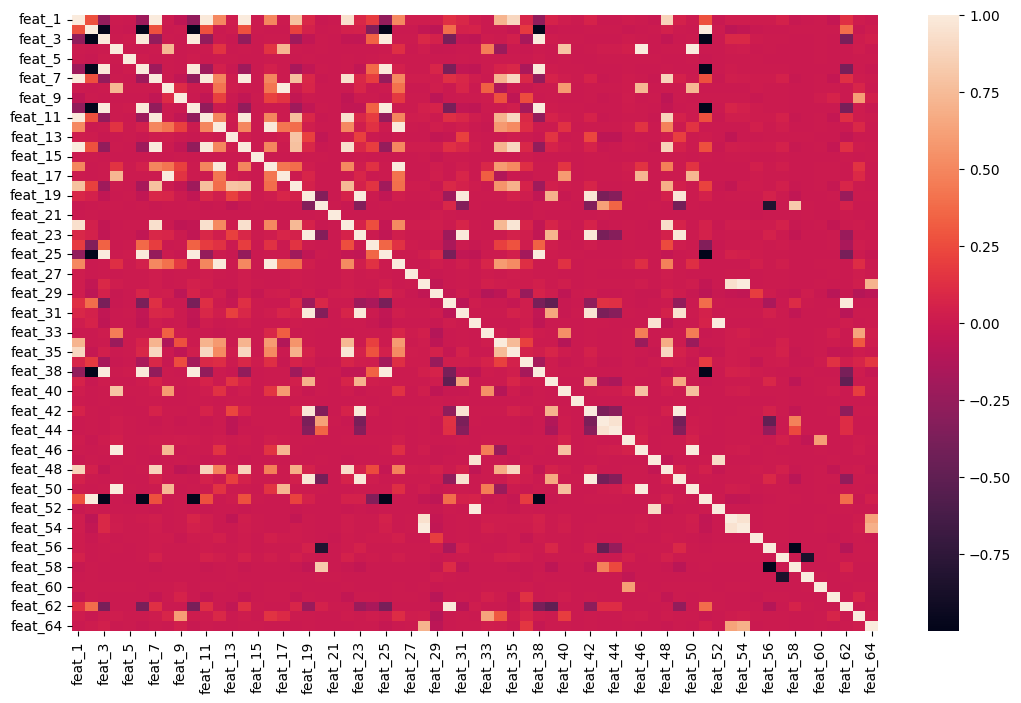

In [56]:
corr = bankrupt_df.drop(columns='bankrupt').corr()
#corr.style.background_gradient(axis=None)
fig,ax = plt.subplots(figsize=(13,8))
sns.heatmap(corr)
plt.show()

**Summary:**

- Our data is imbalanced. This is something we need to address in our data preparation. 
- Many features have missing values that we'll need to impute. And since the features are highly skewed, the best imputation strategy is likely median, not mean. 
- There are multicollinearity issues among features, which means that we should steer clear of linear models, and try a tree-based model (Decision tree) instead.